<a href="https://colab.research.google.com/github/ErnestoLopezF/DSProjects/blob/main/Challenge_RobotTrading_Ernesto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robot Trading
El objetivo de este proyecto es implementar técnicas de análisis de datos para crear un robot que nos permita tomar la decisión de comprar o vender nuestros bitcoins, a partir de data histórica real tomada de *Yahoo! Finance's API*, y el precio actual y la tendencia de la última hora, obtenidos por webscrapping al sitio web *coinmarketcap.com*





## 1. Configuración del ambiente

In [28]:
# Definiendo variables globales
global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

In [29]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import matplotlib as plt

In [30]:
# Verificando ambiente
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.23.5
------
Name: matplotlib
Version: 3.7.1


# 2. Obtención de datos


## 2.1 Precios históricos del Bitcoin
Extraer el histórico de precios del Bitcoin en dólares BTC-USD, tomando el histórico de los últimos 7 días en intervalos de 5 minutos

In [31]:
def importar_base_bitcoin():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision
  import yfinance as yf

  # símbolo de bitcoin en dólares
  simbolo_btc = "BTC-USD"

  # periodo de tiempo de la data y frecuencia
  periodo = "7d"    # 7 días
  frecuencia = "5m" # 5 minutos


  # descarga de datos históricos
  # ver documentación en https://github.com/ranaroussi/yfinance/wiki/Ticker   yf.Ticker(symbol).history(...) -> pd.DataFrame
  df_bitcoin = pd.DataFrame((yf.Ticker(simbolo_btc)).history(period=periodo,interval=frecuencia))

  # si fuera a utilizar el periodo de la fecha entrega original del challenge:
  #df_bitcoin = pd.DataFrame((yf.Ticker(simbolo_btc)).history(start="2023-10-22", end="2023-10-28", interval=frecuencia))

# ejecución y visualización del df
importar_base_bitcoin()
df_bitcoin.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-11-24 00:00:00+00:00,37296.316406,37307.070312,37293.847656,37306.296875,0,0.0,0.0
2023-11-24 00:05:00+00:00,37317.605469,37320.964844,37290.738281,37290.738281,0,0.0,0.0
2023-11-24 00:10:00+00:00,37285.710938,37285.710938,37261.605469,37261.605469,0,0.0,0.0
2023-11-24 00:15:00+00:00,37265.671875,37300.929688,37265.671875,37300.929688,0,0.0,0.0
2023-11-24 00:20:00+00:00,37295.476562,37323.640625,37290.812500,37323.640625,0,0.0,0.0


## 2.2 Indicadores de Tendencias
Realizar webscraping de la página https://coinmarketcap.com/ para extraer el precio actual del Bitcoin BTC en dólares USD y la variación de su precio en la última hora. Convertir el precio a float y guardarlo en la variable  *precio_actual*. En la variable *tendencia* asigno el valor de 'baja' si la variación del precio es negativa, si no, asigno el valor de 'alta'

In [32]:
def extraer_tendencias():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  # biblioteca para scrapping
  from bs4 import BeautifulSoup
  import requests

  # what is my user agent ? -- googlear
  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'}
  url = 'https://coinmarketcap.com/es/'
  respuesta = requests.get(url, headers = headers)
  s = BeautifulSoup(respuesta.content, features = 'lxml')

  #
  div_element = s.find('div', {'class': ['sc-a0353bbc-0 gDrtaY rise','sc-a0353bbc-0 gDrtaY','sc-a0353bbc-0 gDrtaY fall']})
  div_element2 = s.find('span', {'class': ['sc-d55c02b-0 gUnzUB','sc-d55c02b-0 iwhBxy']}) #

  # Extraer el texto

  span_element = div_element.find('span')
  span_element2 = div_element2.find('span')

  variacion = span_element2.get('class')

  price = span_element.text.strip() # .text para obtener el texto, .strip() para eliminar espacios delante y detrás

  precio_actual = float(price.replace("$","").replace(",",""))

  variacion = str(variacion)

  if variacion == "['icon-Caret-up']":
    tendencia = "alta"
  elif variacion == "['icon-Caret-down']":
    tendencia = "baja"
  else:
    tendencia = ""

# ejecución y visualización de las variables
extraer_tendencias()
print('Precio actual del bitcoin en USD: ', precio_actual)
print('Tendencia: ', tendencia)


Precio actual del bitcoin en USD:  37994.73
Tendencia:  alta


# 3. Limpieza de Datos

Crear una copia de la base df_bitcoin en (df_bitcoin_limpio), sin modificar la base original. Además es importante entender su contenido:

**Datetime**: Es el índice del dataframe, y contiene la fecha y hora del intervalo seleccionado, no puede estar duplicado.
**Open**: Contiene el precio del Bitcoin al inicio del intervalo.
**High**: Contiene el precio más alto del Bitcoin durante el intervalo.
**Low**: Contiene el precio más bajo del Bitcoin durante el intervalo.
**Close**: Contiene el precio del Bitcoin al final del intervalo.
**Volume**: Contiene el total de transacciones hechas durante el intervalo.



## 3.1 Explorar y analizar data original

In [33]:
# Muestra información de la base original, sin tratamiento
df_bitcoin.info()
df_bitcoin.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1777 entries, 2023-11-24 00:00:00+00:00 to 2023-11-30 04:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1777 non-null   float64
 1   High          1777 non-null   float64
 2   Low           1777 non-null   float64
 3   Close         1777 non-null   float64
 4   Volume        1777 non-null   int64  
 5   Dividends     1777 non-null   float64
 6   Stock Splits  1777 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 111.1 KB


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1777.00,1777.00,1777.00,1777.00,1.777000e+03,1777.0,1777.0
mean,37602.59,37616.37,37588.34,37602.63,2.195720e+07,0.0,0.0
std,346.15,346.95,345.21,345.97,4.723886e+07,0.0,0.0
min,36756.56,36798.34,36750.13,36780.70,0.000000e+00,0.0,0.0
25%,37340.16,37353.27,37330.42,37340.82,0.000000e+00,0.0,0.0
50%,37719.61,37728.20,37708.75,37719.23,4.425728e+06,0.0,0.0
75%,37818.37,37829.30,37805.80,37817.12,2.526003e+07,0.0,0.0
max,38392.79,38415.34,38361.42,38361.42,5.425500e+08,0.0,0.0


<Axes: >

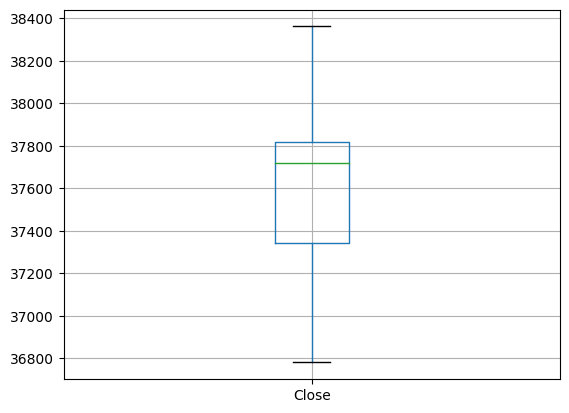

In [34]:
df_bitcoin.boxplot(['Close'])

<Axes: >

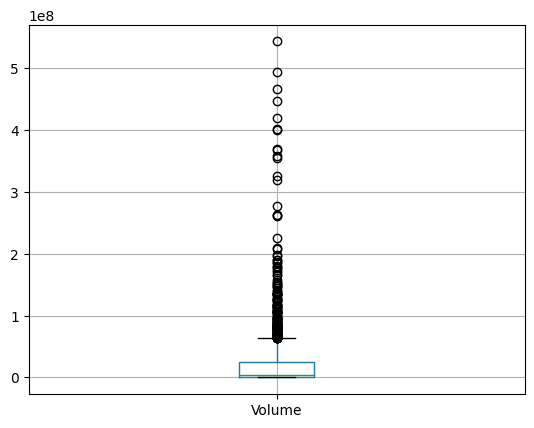

In [35]:
df_bitcoin.boxplot(['Volume'])

## 3.2 Limpiar datos según **duplicados**, **nulos** y valores de **Volume**
Para la limpieza utilizaremos los atributos Datetime, Close y Volume.
Analiza la base df_bitcoin_limpio, identifica duplicados en el índice y trátalos para quedarte con sólo índices únicos.
Luego busca por valores nulos en la columna Close y trátalos.
Verifica que todos los registros de la base tengan un Volume de transacción mayor a 0; caso contrario, elimínalos.

In [36]:
df_bitcoin_limpio = df_bitcoin.copy()
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1777 entries, 2023-11-24 00:00:00+00:00 to 2023-11-30 04:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1777 non-null   float64
 1   High          1777 non-null   float64
 2   Low           1777 non-null   float64
 3   Close         1777 non-null   float64
 4   Volume        1777 non-null   int64  
 5   Dividends     1777 non-null   float64
 6   Stock Splits  1777 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 111.1 KB


In [37]:
# Eliminar índices duplicados
df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]
print(df_bitcoin.shape, df_bitcoin_limpio.shape)
# no hubo indices duplicados


(1777, 7) (1777, 7)


In [38]:
# Tratamiendo de valores nulos en la columna [Close]
# Borrar esas filas
df_bitcoin_limpio = df_bitcoin_limpio.dropna(subset=['Close'])

print(df_bitcoin.shape, df_bitcoin_limpio.shape)
# no había valores nulos en columna 'Close'

(1777, 7) (1777, 7)


In [39]:
# Verificar que todos los registros de la base tengan un Volume de transacción mayor a 0, caso contrario, elimínalos
df_bitcoin_limpio[df_bitcoin_limpio['Volume'] == 0].shape  # --> 865.  Hay que eliminar, es con la instrucción siguiente
df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume']!=0]

print(df_bitcoin.shape, df_bitcoin_limpio.shape) # se eliminaron 779 filas

(1777, 7) (998, 7)


## 3.3 Limpiar datos a partir de quantiles
Deberás identificar y eliminar los outliers en el precio del Bitcoin, columna Close, utiliza un gráfico de boxplot para identificarlos.
Filtra o selecciona únicamente los registros cuyo precio(Close) se encuentren entre el 1er cuartil(Q1) y el 3er cuartil(Q3) del boxplot.


<Axes: >

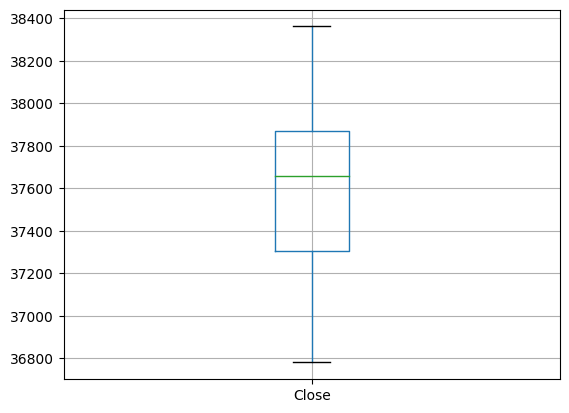

In [40]:
df_bitcoin_limpio.boxplot(['Close'])

<Axes: >

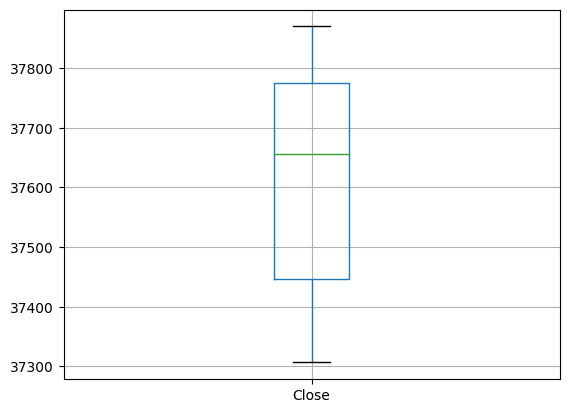

In [41]:
# Calcular Q1 y Q3 de la columna 'Close'
Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
Q3 = df_bitcoin_limpio['Close'].quantile(0.75)

# Filtrar
df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= Q1) & (df_bitcoin_limpio['Close'] <= Q3)]

df_bitcoin_limpio.boxplot(['Close'])

In [42]:
print(Q1,Q3)

37305.80859375 37871.6181640625


In [43]:
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 498 entries, 2023-11-24 00:25:00+00:00 to 2023-11-30 03:25:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          498 non-null    float64
 1   High          498 non-null    float64
 2   Low           498 non-null    float64
 3   Close         498 non-null    float64
 4   Volume        498 non-null    int64  
 5   Dividends     498 non-null    float64
 6   Stock Splits  498 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 31.1 KB


In [44]:
df_bitcoin_limpio['Close'].describe().round(2)

count      498.00
mean     37614.24
std        176.26
min      37306.46
25%      37445.84
50%      37656.49
75%      37775.37
max      37869.92
Name: Close, dtype: float64

## 3.4 Calcular la media a partir de datos limpios
Calcular el precio promedio(Close) de esta selección y guardarlo en la variable media_bitcoin.


In [45]:
media_bitcoin = df_bitcoin_limpio['Close'].mean().round(2)
media_bitcoin

37614.24

In [46]:
# función que calcula la media del precio después de limpiar los datos

def limpieza_datos():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  df_bitcoin_limpio = df_bitcoin.copy()

  # Eliminar índices duplicados
  df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]

  # Tratamiendo de valores nulos en la columna 'Close'
  df_bitcoin_limpio = df_bitcoin_limpio.dropna(subset=['Close'])

  # Filtrar Volume de transacción mayor a 0
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

  # Calcular Q1 y Q3 de la columna 'Close'
  Q1 = df_bitcoin_limpio['Close'].quantile(0.25)
  Q3 = df_bitcoin_limpio['Close'].quantile(0.75)

  # Filtrar
  df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close'] >= Q1) & (df_bitcoin_limpio['Close'] <= Q3)]

  # Calcular el precio promedio de (Close) de esta selección y guardarlo en la variable media_bitcoin
  media_bitcoin = df_bitcoin_limpio['Close'].mean().round(2)

  return media_bitcoin

In [47]:
limpieza_datos()

37614.24

# 4. Tomar Decisiones
La variable *algoritmo_decision* tomará valor:

**‘Vender’** Si el precio actual es mayor/igual que el precio promedio y la tendencia es de baja.

**‘Comprar’** Si el precio actual es menor que el precio promedio y la tendencia es de alta .

**'Esperar'** Si ninguna de las 2 condiciones anteriores se cumple.



In [48]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  #media_bitcoin = limpieza_datos()

  if (precio_actual >= media_bitcoin) & (tendencia == 'baja'):
    algoritmo_decision = 'Vender'
  elif (precio_actual < media_bitcoin) & (tendencia == 'alta'):
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Esperar'

  return algoritmo_decision

In [49]:
tomar_decisiones()

'Esperar'

# 5. Visualización
Adiciona una nueva columna (Promedio) al dataframe original df_bitcoin y almacena el valor de nuestra variable media_bitcoin.
Configura el tamaño del gráfico en una proporción de 16x5.
Adiciona un título al gráfico.
Usando el método plot()dibuja una línea en el gráfico, con los datos del índice y la columna Close de la base df_bitcoin.
Usando el método plot()dibuja una línea en el gráfico, con los datos del índice y la columna Promedio de la base df_bitcoin.
Usando el método annotate()muestra un mensaje dentro del gráfico con la decisión calculada del algoritmo.
Finalmente, usando el método show()muestra en pantalla el gráfico que acabamos de configurar.

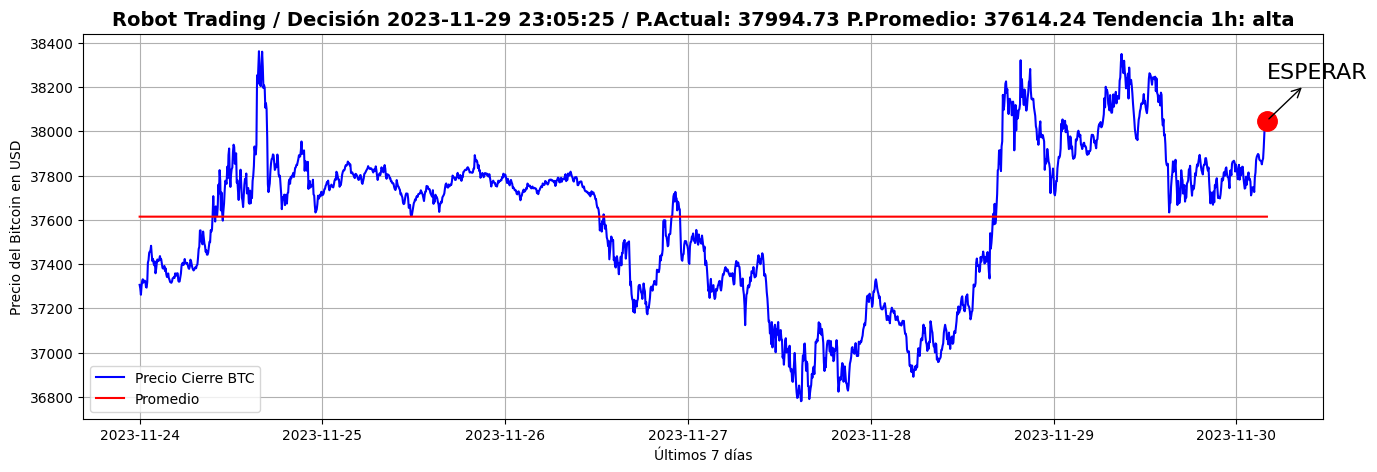

In [50]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision, color_decision

  if algoritmo_decision == 'Vender':
    color_decision = 'green'
  elif algoritmo_decision =='Comprar':
    color_decision = 'red'
  else:
    color_decision = 'black'


  # nueva columna
  df_bitcoin['Promedio'] = media_bitcoin

  # tamaño 16x5
  plt.figure(figsize=(16, 5))

  # obtener hora local actual para incluirla en el título del gráfico
  hora_actual_UTC = datetime.now()
  hora_local = hora_actual_UTC - timedelta(hours=5) #Restar 5h a la fecha UTC actual
  hora_local_str = hora_local.strftime('%Y-%m-%d %H:%M:%S')

  # título del gráfico
  plt.title(f"Robot Trading / Decisión {hora_local_str} / P.Actual: {precio_actual} P.Promedio: {media_bitcoin} Tendencia 1h: {tendencia}", fontsize = 14, weight = 'bold')
  plt.xlabel('Últimos 7 días')
  plt.ylabel('Precio del Bitcoin en USD')
  # plotear los datos del índice y la columna [Close] de la base df_bitcoin
  plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Precio Cierre BTC', linestyle='-', color = 'blue')

  # dibujar una línea con los datos del índice y la columna [Promedio] de la base df_bitcoin
  plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], label='Promedio', linestyle='-', color = 'red')

  # muestra un mensaje dentro del gráfico con la decisión calculada del algoritmo
  plt.plot(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1], 'ro', markersize=14) # plotear el momento de la decisión
  plt.annotate(algoritmo_decision.upper(), # texto de la nota
               xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1] ), # coordenadas del (último) punto a anotar
               xytext=(df_bitcoin.index[-1] , df_bitcoin['Close'].iloc[-1] * 1.005 ), # posición de la nota
               arrowprops=dict(color=color_decision, arrowstyle='<-'),  # flecha e/ [xy] y [xytext]
               fontsize=16, color=color_decision) # tamaño y color de la nota

  # mostrar el gráfico configurado
  plt.legend()
  plt.grid()
  plt.show()

# ejecución de la función
visualizacion()



# 6. Automatización
Solución automática para nuevos lotes de información
Mostrar el histórico de precios del Bitcoin y la decisión del algoritmo en tiempo real, basado en datos normalizados y limpios, que se actualizarán cada 5 minutos

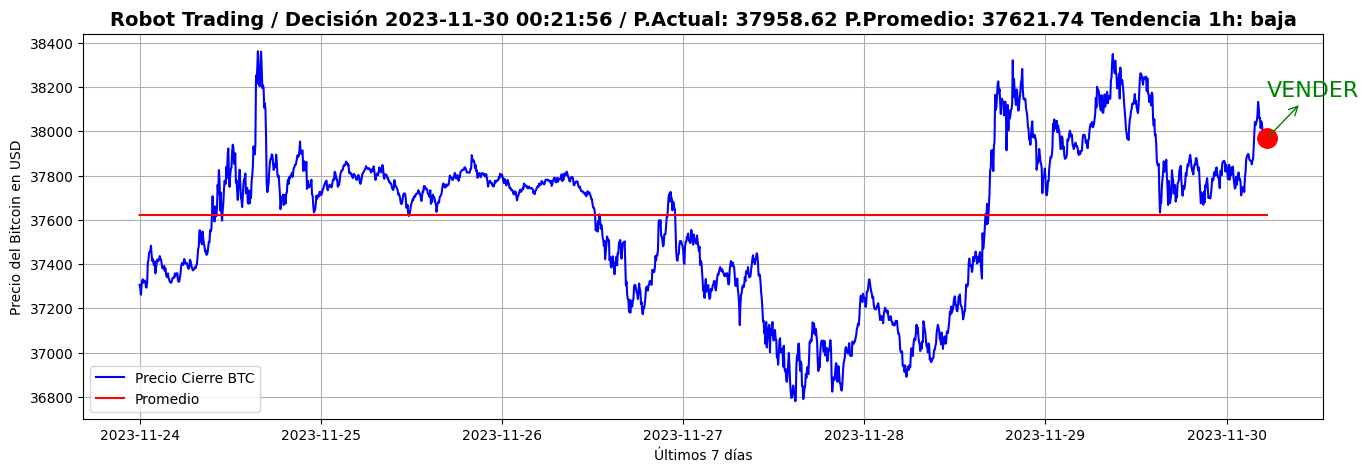

In [ ]:
from IPython.display import clear_output
import time

# definir un loop infinito
while True:
    # borrar los resultados de la pantalla antes de imprimir un nuevo gráfico, y así evitar tener más de un gráfico en la pantalla
    clear_output(wait=True)

    # importar data bitcoin
    importar_base_bitcoin()

    # obtener tendencia
    extraer_tendencias()

    # limpiar datos
    limpieza_datos()

    # tomar decisión
    tomar_decisiones()

    # visualizar
    visualizacion()

    # ejecutar el código cada 5 minutos
    time.sleep(300)

